
<img src="../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">EM Connectomics</h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain </h2> 
<h3 align="center">Monday, August 29, 2022</h3> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>In this session, we introduce how to query the anotation database and give a flavor of how to use the results to do some simple analysis. By the end, you should be able to query for neurons, query for synapses between those neurons, and visualize the neurons and synapes.

</div>



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Background</h2>

<p>
This dataset is part of a collaboration between the Tolias lab at Baylor,
the Allen Institute, and Sebastian Seung's lab at Princeton University,
as part of the IARPA Microns project.  
</p>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Local setup instructions</h2>

<p>
Because this dataset is part of a collaboration, it has not been packaged 
through the usual AllenSDK mechanism.  Working with Princeton we have developed  packages for querying and visualizing the data. They should be installed by creating a new anaconda environment using the environment.yml file found in this repo. 
</p>





<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Drive Path</h2>
First we need to know where the data is on your system.  If you are running on Linux or Windows, edit this cell to reflect where the data is.  If on AWS or mac the location here is likely correct.

</div>


In [1]:
import platform
import os

platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2022/em_connectomics"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/em_connectomics"
elif ('amzn' in platstring):
    # then on AWS
    data_root = "/data/swdb2022-em"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2021/em_connectomics"
    
# OR if you'd like to override the auto options
# data_root = "."
mesh_folder = os.path.join(data_root, 'meshes')
skeleton_folder = os.path.join(data_root, 'proofread_skeletons')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Import the key modules</h2>
Our analysis workflows use a couple of special purpose packages we have developed. Here, we are going to look at the CAVEclient (Connectome Annotation Versioning Engine), our package that quickly performs simple analysis queries and produces tidy Pandas dataframes.
</div>

In [2]:
# this is the EM specific package for querying the EM data
from caveclient import CAVEclient


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Import some of our favorite modules</h2>
Our analysis workflows uses many of the common scientific computing packages like Numpy and Pandas.
</div>

In [3]:
# import some of our favorite packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Setting up a CAVE account </h2>

CAVE is the Connectome Annotation Versioning Engine.
It is a collection of services which manage proofreading and data annotation for large scale connectomics dataset.
These services were developed during the IARPA MICrONS program, but now support data from several projects including FlyWire.  You need to have an account on CAVE to use its services.

To get an account please first go to this [website](https://minnie.microns-daf.com/materialize/views/datastack/minnie65_public_v117)

You should be prompted to login with a google account and then you must seperately accept the terms and conditions.

Once you have registered, you can then follow along this notebook.
This notebook will show you how to get a programatic token that you can use to authenticate to the services in order to make queries. The token can then be used on different computers.

<h2>Setting key parameters </h2>
A 'datastack' is a combination of image and segmentation data.  The cortical mm^3 datastack that we are going to use is called `minnie65_public_v343` named because it is approximately 65% of the whole volume, and its the public releasse that corresponds to the 343th iteration of proofreading results we aggregated. (one of two we made public v117 being the other)
</div>


In [4]:
client = CAVEclient()

# this will detect if this computer is setup already
if not os.path.isfile(client.auth._token_file):
    # this assumes that you need to setup a token
    # client.auth.setup_token(make_new=True)

    # if you have already used MICRONS or FlyWire,
    # and setup a different computer you might 
    # want to use this instead to not invalidate your old tokens
    client.auth.setup_token(make_new=False)

In [5]:
# if you have not yet setup this computer, uncomment this below line
# paste the token from the website in, and run the line

# client.auth.save_token(token="paste_token_here", overwrite=True)

# then comment or delete the line as you don't need to run it on this computer  again

In [6]:
datastack_name = 'minnie65_public_v343'

client = CAVEclient(datastack_name)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Terms of Service Error</h2>
If for some reason you are getting an error that says you haven't signed the terms of service, visit this link.

<a href="https://global.daf-apis.com/sticky_auth/api/v1/tos/2/accept"> Microns Public TOS </a>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Client Basics</h2>
The client lets you connect to a number of different services via service specific clients, and you can read about all of them in  <a href="https://caveclient.readthedocs.io/">the CAVEclient documentation</a>.

The base client class has properties that let you access the sub-clients for each service. 

For this notebook however we will focus on the 'materialize' sub-client which lets you interact with the 'materialization' service to access tables of annotations on the data, including cells, nuclei, cell types and synapses. 

To see what tables are available, use the 'get_tables' method on the materialize sub-client.
</div>

In [7]:
client.materialize.get_tables()

['synapses_pni_2',
 'nucleus_neuron_svm',
 'nucleus_detection_v0',
 'functional_coreg',
 'allen_v1_column_types_slanted',
 'aibs_column_nonneuronal',
 'func_unit_em_match_release',
 'proofreading_status_public_release',
 'aibs_soma_nuc_metamodel_preds_v117']

In [37]:
# For each table you can get metadata about that table
client.materialize.get_table_metadata('nucleus_detection_v0')
# in this case you can see that it's a table that contains a list of all the automated
# nucleus detections in the dataset, useful for finding cells with cell bodies.

{'table_name': 'nucleus_detection_v0',
 'aligned_volume': 'minnie65_phase3',
 'created': '2020-09-28T22:39:06.523707',
 'valid': True,
 'schema': 'nucleus_detection',
 'id': 8214,
 'schema_type': 'nucleus_detection',
 'user_id': '121',
 'reference_table': None,
 'description': 'A table of nuclei detections from a nucleus detection model developed by Shang Mu, Leila Elabbady, Gayathri Mahalingam and Forrest Collman. Pt is the centroid of the nucleus detection. id corresponds to the flat_segmentation_source segmentID. Only included nucleus detections of volume>25 um^3, below which detections are false positives, though some false positives above that threshold remain. ',
 'flat_segmentation_source': 'precomputed://https://bossdb-open-data.s3.amazonaws.com/iarpa_microns/minnie/minnie65/nuclei',
 'voxel_resolution': [4.0, 4.0, 40.0]}

In [9]:
# and how many annotations are in it
# the maybe most important table is the synapse table (synapses_pni_2)
# which has >330 million synapses, so querying its length takes a long time
client.materialize.get_annotation_count('nucleus_detection_v0')


144120

In [10]:
# lets look at the proofreading status table
# if you ask for the whole thing, the client will give you the first 200K rows
# which is good enough to cover everything other than synapses
prf_df= client.materialize.query_table('proofreading_status_public_release')
prf_df.head()

,id,valid,pt_supervoxel_id,pt_root_id,valid_id,status_dendrite,status_axon,pt_position
0,4,t,91077153340676495,864691135355207375,864691135355207375,extended,non,"[191424, 209888, 22845]"
1,7,t,91570559116360958,864691136602027473,864691136602027473,extended,non,"[194864, 216128, 22205]"
2,8,t,90444453118345856,864691135866846742,864691135866846742,extended,non,"[186768, 214288, 22811]"
3,9,t,89741246779911895,864691135445832338,864691135445832338,extended,non,"[181312, 217904, 23251]"
4,13,t,91499640750531825,864691135569255558,864691135569255558,extended,non,"[194112, 212064, 23175]"


In [39]:
# so what do those columns mean?
# you can check the metadata!
prf_metadata=client.materialize.get_table_metadata('proofreading_status_public_release')
# you could print it out like this, but we've added it to the markdown below
# with the column descriptions
#prf_metadata['description']

<h3> Proofreading Status Descriptions</h3>
prf_metadata['description']="The proofreading status of neurons that have been comprehensively proofread within this version. Axon and dendrite compartment status are marked separately under 'axon_status' and 'dendrite_status', as proofreading effort was applied differently to the different compartments in some cells. There are three possible status values for each compartment: 'non' indicates no comprehensive proofreading. 'clean' indicates that all false merges have been removed, but all tips have not necessarily been followed. 'extended' indicates that the cell is both clean and all tips have been followed as far as a proofreader was able to. The 'pt_position' is at a cell body or similar core position for the cell. The column 'valid_id' provides the root id when the proofreading was last checked. If the current root id in 'pt_root_id' is not the same as 'valid_id', there is no guarantee that the proofreading status is correct. Very small false axon merges (axon fragments approximately 5 microns or less in length) were considered acceptable for clean neurites. Note that this table does not list all edited cells, but only those with comprehensive effort toward the status mentioned here. Table compiled by Sven Dorkenwald and Casey Schneider-Mizell, including work by many proofreaders and data maintained by Stelios Papadopoulos."
<table style={float:left}>
    <tr>
        <td><h4>column</h4></td>
        <td><h4>description</h4></td>
    </tr> 
    <tr>
        <td>valid</td>
        <td>A bookkeeping column, should always be 't'</td>
    </tr>
    <tr>
        <td>pt_position</td>
        <td>This is the x,y,z location in voxels of the point that was annotated here as being at this cells soma location. Note, this table has a voxel resolution of 4,4,40 nm, and so you might want to convert this column to a nm position, using thew.  </td>
    </tr>
    <tr>
        <td>pt_supervoxel_id</td>
        <td>You can generally ignore this column, we keep it for bookkeeping in order to make it easier to update this annotation when the segmentation changes.  </td>
    </tr>
    <tr>
        <td>pt_root_id</td>
        <td>This is the unique ID of the 'root' object in the segmentation, sometimes we refer to this as a segmentation id or a cell id.</td>
    </tr>
    <tr>
        <td>valid_id</td>
        <td>This is the ID of the object when this proofreading status was applied, for this release, this column matches the pt_root_id and so can be ignored.  Its here to help alert us if the object changed since the human who judged this neuron to be 'clean' for example.  In such case its possible theoretically that the cell is no longer 'clean'.</td>
    </tr>
    <tr>
        <td>status_dendrite</td>
        <td>There are three possible status values for each compartment: 'non' indicates no comprehensive proofreading. 'clean' indicates that all false merges have been removed, but all tips have not necessarily been followed. 'extended' indicates that the cell is both clean and all tips have been followed as far as a proofreader was able to. 
        </td>
    </tr> 
    <tr>
        <td>status_axon</td>
        <td>Same as status_dendrite but for axon. You should only trust outputs of cells with at least clean, and cells with extended will have the largest number of trustable outputs for its cell type </td>
    </tr> 
    <tr>
        <td>pt_position</td>
        <td>A location at a cell body or similar core position for the cell. (units from metadata are [4,4,40] nm voxels) </td>
    </tr> 
    
</table>



In [12]:
# lets look at how many cells there are of each dendrite status
prf_df.status_dendrite.value_counts()

extended    636
clean       115
non          13
Name: status_dendrite, dtype: int64

In [13]:
# lets look at how many cells there are of each axon status
prf_df.status_axon.value_counts()

non         354
extended    289
clean       121
Name: status_axon, dtype: int64

In [41]:
# with the client we can do simple filters based upon
# the column name and values you want to include or exclude
# this will only pull those columns from the server
# with these keyword arguments
# filter_in_dict: a dictionary with column names as keys
#   values are a list of acceptable values in that column
#   only rows that have a value in the list for that column
#   will be returned by query
# 
# filter_out_dict: a dictionary with column names as keys
#   values are a list of unacceptable values for a row
#   rows that have a value in the list for that column
#   will excluded from being returned by the query
#
# filter_equal_dict: a dictionary with column names as keys
#   values are the value that this column must be
#   only rows that have that value for that column
#   will be returned by the query
#
# all these filters will be applied successively, effectively
# createing an AND between all the conditions.

# let get all the cells with extended axons
ext_axon_df = client.materialize.query_table('proofreading_status_public_release',
                                             filter_equal_dict={'status_axon':'extended'})

# lets get all the cells with any dendritic proofreading (clean or extended)
clean_dend_df = client.materialize.query_table('proofreading_status_public_release',
                                              filter_out_dict={'status_dendrite':['non']})

# how many in each
ext_axon_df.shape, clean_dend_df.shape

((289, 8), (751, 8))

In [42]:
# Sometimes its useful to get positions a column of numpy arrays
# which is the default
ext_axon_df.head().pt_position

0    [187840, 207232, 22680]
1    [173008, 205856, 20391]
2    [174592, 206608, 20768]
3    [168992, 203840, 20211]
4    [304080, 101984, 21853]
Name: pt_position, dtype: object

In [43]:
# sometimes seperate split out columns
# the new columns will just get _x, _y, _z suffixes
# (this is also faster in general)
ext_axon_df = client.materialize.query_table('proofreading_status_public_release',
                                             filter_equal_dict={'status_axon':'extended'},
                                             split_positions=True)
ext_axon_df.head()[['pt_position_x','pt_position_y', 'pt_position_z']]

,pt_position_x,pt_position_y,pt_position_z
0,187840,207232,22680
1,173008,205856,20391
2,174592,206608,20768
3,168992,203840,20211
4,304080,101984,21853


In [45]:
# note, by default it will return all X_position columns in the units specified in the metadata
# the voxel resolution is a length 3 list that says what units the X, Y, Z positions were given in nm
# in other words, how many nanometers does a value of 1 in the X, Y, and Z coordinates represent
# a 'resolution' of 4,4,40 , means a value of [1,1,1] is located at 4nm, 4nm, 40nm in space 
prf_metadata['voxel_resolution']

[4.0, 4.0, 40.0]

In [46]:
# but if you want a different unit, for example in pure nanometers you can ask for that
# using desired_resolution= (1,1,1) or [1,1,1] for 1nm per x,y,z unit
ext_axon_df = client.materialize.query_table('proofreading_status_public_release',
                                             filter_equal_dict={'status_axon':'extended'},
                                             split_positions=True,
                                             desired_resolution=(1,1,1))
ext_axon_df.head()[['pt_position_x','pt_position_y', 'pt_position_z']]

,pt_position_x,pt_position_y,pt_position_z
0,751360.0,828928.0,907200.0
1,692032.0,823424.0,815640.0
2,698368.0,826432.0,830720.0
3,675968.0,815360.0,808440.0
4,1216320.0,407936.0,874120.0


In [47]:
# or maybe you don't want such large numbers and would like microns
# this would be desired_resolution=(1000,1000,1000), resulting in smaller values
ext_axon_df = client.materialize.query_table('proofreading_status_public_release',
                                             filter_equal_dict={'status_axon':'extended'},
                                             split_positions=True,
                                             desired_resolution=(1000,1000,1000))
ext_axon_df.head()[['pt_position_x','pt_position_y', 'pt_position_z']]

,pt_position_x,pt_position_y,pt_position_z
0,751.360,828.928,907.20
1,692.032,823.424,815.64
2,698.368,826.432,830.72
3,675.968,815.360,808.44
4,1216.320,407.936,874.12


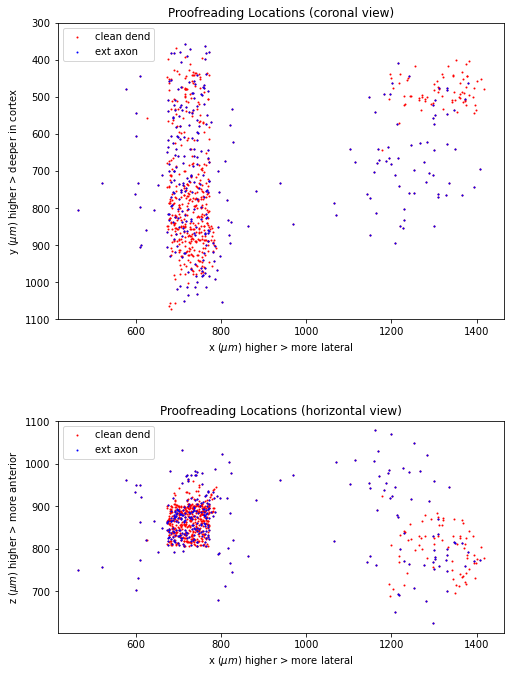

In [54]:
# Let's use this to plot the locations of the annotations

# First let's query cells for those whose axons have a status of extended.
# In the query, we will split the positions into seperate columns
# and convert the units to um, by specifying units of 1000nm for all 3 dimensions
clean_dend_df = client.materialize.query_table('proofreading_status_public_release',
                                              filter_in_dict={'status_dendrite':['clean', 'extended']},
                                              split_positions=True,
                                              desired_resolution=[1000,1000,1000])
ext_axon_df = client.materialize.query_table('proofreading_status_public_release',
                                             filter_equal_dict={'status_axon':'extended'},
                                             split_positions=True,
                                             desired_resolution=(1000,1000,1000))

# make a new axis with two subplots
fig = plt.figure(figsize=(8,12))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)

# plot each dataframe in a different color
ax1.scatter(clean_dend_df.pt_position_x, clean_dend_df.pt_position_y, c='r',s=1)
ax1.scatter(ext_axon_df.pt_position_x, ext_axon_df.pt_position_y, c='b',s=1)


# label some axis, make x,y scaling same
ax1.set_xlabel('x ($\mu m$) higher > more lateral')
ax1.set_ylabel('y ($\mu m$) higher > deeper in cortex')
# to keep the pia 'up'
ax1.set_ylim(1100,300)
ax1.set_title('Proofreading Locations (coronal view)')

# plot the same thing in x,z
ax2.scatter(clean_dend_df.pt_position_x, clean_dend_df.pt_position_z, c='r', s=1)
ax2.scatter(ext_axon_df.pt_position_x, ext_axon_df.pt_position_z, c='b',s=1)

ax2.set_xlabel('x ($\mu m$) higher > more lateral')
ax2.set_ylabel('z ($\mu m$) higher > more anterior')
ax2.set_title('Proofreading Locations (horizontal view)')
ax2.set_aspect('equal')
ax1.legend(['clean dend', 'ext axon'])
ax2.legend(['clean dend', 'ext axon'])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Coordinate System</h2>
Below is a diagram to help you visualize the coordinate system plotted above.  
</div>


<img src="../resources/SWDB_EM_CoordinateSystem_v0.png"> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Querying for synapses</h2>
Let's pick out a cell ID of an excitatory neuron and then find all the synapses onto that neuron</div>


In [20]:
neuron_id  = clean_dend_df.iloc[0].pt_root_id
neuron_id

864691135355207375

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now we are ready to query synapses for this neuron. Because the analysis database can, in principle, handle multiple different sources of synapses, we have to specify which synapse table we want to use. The current table holding the most up to date automated synapse detection is called `synapses_pni_2`.  The "info" service has stored the default synapse table you should use for each datastack so you don't need to remember it.

Because synapses are such a common query, we have written a wrapper method `synapse_query` which uses the default synapse table and simplifies the syntax. Here is a list of it's key arguments ..

- `post_ids`: Use to specify that you want synpases onto these neurons, in other words, you want inputs to these neurons. 
- `pre_ids`: Use to specify that you want synapses from these neurons, in other words, you want outputs from these neurons. 

Setting both `pre_ids` and `post_ids` will return only synapses that are from the `pre_ids` onto the `post_ids`.

If you pass neither you are essentially asking for all the synapses, 330 million of them, several hundred gigabytes of data.
We won't do that, and in general the service will only give you the first 200K of any query.
You'll see a warning if you hit this limit.

You also have the other options available to you to split_positions and convert units with desired_resolution if you want.
</div>

In [21]:
print(client.materialize.synapse_table)
post_synapse_df = client.materialize.synapse_query(post_ids = neuron_id)
# lets post the shape to see how many synapses we have
print(post_synapse_df.shape)
# and take a peak at the whole dataframe
post_synapse_df.head()

synapses_pni_2
(2153, 10)


,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position
0,183361830,t,90936347065790923,864691136577758484,90936347065797444,864691135355207375,3180,"[190268, 209432, 22392]","[190214, 209538, 22400]","[190251, 209518, 22399]"
1,148880070,t,88052259480540761,864691136850126446,88052259480523401,864691135355207375,7360,"[169368, 216848, 23121]","[169400, 216950, 23113]","[169405, 216905, 23124]"
2,183244702,t,91008983485591311,864691135209212230,91008983485587468,864691135355207375,1076,"[190802, 226240, 21899]","[190818, 226208, 21888]","[190772, 226243, 21891]"
3,169816275,t,89741178060237102,864691135599313860,89670809316055143,864691135355207375,13768,"[181342, 217436, 23070]","[181254, 217484, 23078]","[181284, 217478, 23076]"
4,177789108,t,90709297780185782,864691134892313102,90709297780172814,864691135355207375,5432,"[188806, 90392, 21174]","[188838, 90378, 21166]","[188842, 90390, 21169]"


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Each row in this table is a single synapse. You should see that the value in the post_pt_root_id column is the same for all, and equals the id you selected above. </br>


<h3> Synapse Table Descriptions</h3>
Here's a breakdown of what each of those columns mean.
</div>

<table style={float:left}>
    <tr>
        <td><h4>column</h4></td>
        <td><h4>description</h4></td>
    </tr> 
    <tr>
        <td>id</td>
        <td>The ID that is specific to this synapse annotation</td>
    </tr>
    <tr>
        <td>pre_pt_supervoxel_id</td>
        <td>a bookkeeping column for the presynaptic side </td>
    </tr>
    <tr>
        <td>pre_pt_root_id</td>
        <td>the ID of the cell on the presynaptic side</td>
    </tr>
    <tr>
        <td>post_pt_supervoxel_id</td>
        <td>Same bookkeeping column as pre_pt but for the post synaptic side.</td>
    </tr>
    <tr>
        <td>post_pt_root_id</td>
        <td>Same as pre_pt but for the post synaptic side</td>
    </tr>
    <tr>
        <td>size</td>
        <td>The size of the synaptic cleft in units of 4,4,40 voxels.</td>
    </tr>
    <tr>
        <td>pre_pt_position</td>
        <td>a point that is in the pre-synaptic terminal of this synapse  </td>
    </tr>
    <tr>
        <td>post_pt_position</td>
        <td>Same as pre_pt but for the post synaptic side.</td>
    </tr>
    <tr>
        <td>ctr_pt_position</td>
        <td>a point that is on the center of the synapse</td>
    </tr>
</table>
<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


<h5>Note in this table there are 3 position columns. Like the other table, they will be given by default in the units specified in the metadata (4,4,40 nm), which matches the default Neuroglancer coordinates.</h5>
</div>

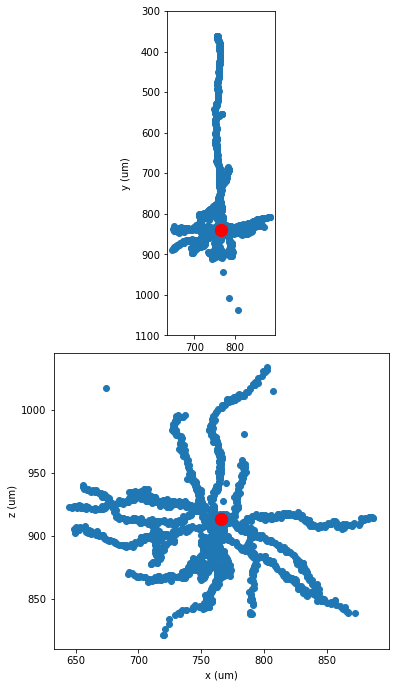

In [22]:
# Lets query this neuron again, but now splitting columns and converting to um
post_synapse_df = client.materialize.synapse_query(post_ids = neuron_id,
                                                   desired_resolution=(1000,1000,1000))

# Lets make a matrix of synapse positions for this neuron
syn_pos_nm = np.vstack(post_synapse_df['ctr_pt_position'].values)
# and plot their positions in x,y along with the soma position as a red circle
fig = plt.figure(figsize=(6,12))
ax1 = fig.add_subplot(2, 1, 1, aspect='equal')
ax2 = fig.add_subplot(2, 1, 2,  aspect='equal')
ax1.scatter(syn_pos_nm[:,0], syn_pos_nm[:,1])

# add the soma position as a red circle
soma_pos = clean_dend_df[['pt_position_x','pt_position_y','pt_position_z']].values
ax1.scatter([soma_pos[0,0]],[soma_pos[0,1]],c='r',s=150)
ax1.set_xlabel('x (um)')
ax1.set_ylabel('y (um)')
ax1.set_ylim(1100,300)

ax2.scatter(syn_pos_nm[:,0], syn_pos_nm[:,2])

# add the soma position as a red circle
ax2.scatter([soma_pos[0,0]],[soma_pos[0,2]],c='r',s=150)
ax2.set_xlabel('x (um)')
ax2.set_ylabel('z (um)')
plt.subplots_adjust(hspace=0.01)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now lets figure out which excitatory neuron makes the most synapses onto this neuron
</div>

In [55]:
# We can use pandas groupby to count number of synapses from different neurons.
# If we use groupby followed by transform with len as the aggregation function
# We can return a series which is the same length as the dataframe (one row per synapse)
# but contains how many other synapses are in that connection.
# Since length is the same result no matter what the column contains,
# you can pick any column to aggregate on.  Here we choose the 'id' column

syn_in_conn=post_synapse_df.groupby('pre_pt_root_id')['id'].transform(len)
# save this result in a new column
post_synapse_df['syn_in_conn']=syn_in_conn
post_synapse_df[['id', 'pre_pt_root_id', 'size','syn_in_conn']].sort_values('syn_in_conn', ascending=False).head()

,id,pre_pt_root_id,size,syn_in_conn
1867,190081077,864691135303399847,5532,6
896,181730232,864691135303399847,4400,6
1520,181730731,864691135640423876,6180,6
551,183176890,864691135303399847,3156,6
526,183178227,864691135640423876,3148,6


In [24]:

# are any of these synapses from our list of extended axons?
is_from_extended = post_synapse_df.pre_pt_root_id.isin(ext_axon_df.pt_root_id.values)
extended_to_neuron_df=post_synapse_df[is_from_extended]
extended_to_neuron_df[['id',
                'post_pt_root_id',
                'pre_pt_root_id',
                'syn_in_conn',
                'size']]

,id,post_pt_root_id,pre_pt_root_id,syn_in_conn,size
188,183361942,864691135355207375,864691135538472562,5,1884
289,183204466,864691135355207375,864691136423071535,3,2208
367,195041615,864691135355207375,864691136329289962,1,2160
413,183178374,864691135355207375,864691137053995126,1,8980
453,183176375,864691135355207375,864691136099960181,2,3880
477,183178523,864691135355207375,864691135926631636,1,3252
507,169081334,864691135355207375,864691135538472562,5,856
514,169003861,864691135355207375,864691135538472562,5,3472
551,183176890,864691135355207375,864691135303399847,6,3156
635,183178487,864691135355207375,864691135303399847,6,4196


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Lets get the ID of the neuron that has the largest number of synapses onto this neuron
</div>

In [56]:
# find the neuron with the most synapses
max_input_idx = extended_to_neuron_df.syn_in_conn.idxmax()
max_input_neuron = extended_to_neuron_df.loc[max_input_idx].pre_pt_root_id
print(max_input_neuron)

# Print out the synapses from this neuron as a double check.
# You can see there are 6 of them
# which is the largest value of syn_in_conn in the above table
extended_to_neuron_df[extended_to_neuron_df.pre_pt_root_id == max_input_neuron]

864691135303399847


,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position,syn_in_conn
551,183176890,t,90725240900123743,864691135303399847,90725240900140264,864691135355207375,3156,"[754.456, 838.264, 907.9200000000001]","[754.8240000000001, 838.296, 908.48]","[754.6320000000001, 838.208, 908.16]",6
635,183178487,t,91147247206717083,864691135303399847,91147247206712241,864691135355207375,4196,"[766.8240000000001, 831.144, 906.44]","[766.496, 831.208, 906.2]","[766.6, 831.432, 906.5600000000001]",6
732,183204362,t,91076878462543837,864691135303399847,91147247206697278,864691135355207375,4928,"[765.936, 831.248, 906.24]","[766.112, 831.2, 905.84]","[766.016, 831.144, 906.04]",6
896,181730232,t,90866047108317519,864691135303399847,90866047108308777,864691135355207375,4400,"[759.224, 838.688, 919.4]","[759.6320000000001, 838.64, 919.16]","[759.448, 838.568, 919.4]",6
1867,190081077,t,91147109701005276,864691135303399847,91147109701010829,864691135355207375,5532,"[767.648, 826.912, 899.6]","[768.064, 826.424, 899.96]","[767.652, 826.832, 899.72]",6
1969,183362185,t,91006578371072102,864691135303399847,91006578371060828,864691135355207375,5208,"[763.768, 834.216, 898.2]","[763.344, 834.104, 898.0]","[763.576, 833.96, 898.08]",6


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Linking synapses to cell types</h2>
You might want to link synapses to the cell bodies or cell classes of the pre or post-synaptic cells.  To do this, you want to 'merge' (See <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html"> pandas merge docs </a> ) the information between a synapse table and a table of cells. </div>

We have a few different tables that have lists of cells that have different kinds of metadata and meanings. 

<table style={float:left}>
    <tr>
        <td><h4>tables of cells</h4></td>
        <td><h4>description</h4></td>
    </tr> 
    <tr>
    <td>nucleus_detection_v0</td>
    <td>a table with every nucleus detection in the dataset (includes some false positives)</td>
    </tr>
    <tr>
    <td>aibs_soma_nuc_metamodel_preds_v117</td>
    <td>A machine learning model with cell type predictions for 86916 cells based on soma and nucleus features, references nucleus_detection_v0</td>
    </tr>
    <tr>
    <td>nucleus_neuron_svm</td>
    <td>A machine learning model with predictions for 171818 nucleus detectionss, predicts neurons from non-neurons (glia+errors)</td>
    </tr>
    <tr>
    <td>allen_v1_column_types_slanted</td>
    <td>A table of human expert powered neuronal cell type calls from the "column"</td>
    </tr>
    <tr>
    <td>aibs_column_nonneuronal</td>
    <td>A table of human expert powered non-neuronal cell type calls from the "column"</td>
    </tr>
    <tr>
    <td>functional_coreg</td>
    <td>A list of 9608 cells that have functional coregistration, prioritized towards targets of excitatory neurons with extended axons </td>
    </tr>
    <tr>
    <td>func_unit_em_match_release</td>
    <td>A list of 100 cells that have functional coregistration spread evenly throughout the volume. </td>
    </tr>

</table>

In [26]:
# lets pull out the table that lists the cell type predictions in the dataset
# it will get automatically merged with the nucleus_dection_v0 table
# to give us the positions of those nuclei.
neuron_soma_df = client.materialize.query_table('aibs_soma_nuc_metamodel_preds_v117')
neuron_soma_df.head()


,id,valid,target_id,classification_system,cell_type,id_ref,valid__ref,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position
0,553,t,498173,aibs_neuronal,6P-IT,498173,t,308.176159,103884538719281829,864691136091295156,"[284688, 211936, 15566]","[nan, nan, nan]","[nan, nan, nan]"
1,4509,t,487329,aibs_neuronal,MC,487329,t,295.937638,105279407463397326,864691135975935434,"[294544, 118624, 21745]","[nan, nan, nan]","[nan, nan, nan]"
2,4693,t,106662,aibs_neuronal,23P,106662,t,230.148178,79524515478544304,864691136084076652,"[107056, 119248, 19414]","[nan, nan, nan]","[nan, nan, nan]"
3,5061,t,271350,aibs_neuronal,6P-CT,271350,t,305.328128,87351114324194368,864691135937342005,"[163920, 235968, 20875]","[nan, nan, nan]","[nan, nan, nan]"
4,8652,t,456040,aibs_neuronal,MC,456040,t,257.463910,101129507251445952,864691136084057196,"[264544, 132528, 23988]","[nan, nan, nan]","[nan, nan, nan]"


In [27]:
# where did these predictions come from?
client.materialize.get_table_metadata('aibs_soma_nuc_metamodel_preds_v117')['description']

'This table contains cell-type predictions for cells throughout the entire dataset, based on a soma and nucleus feature trained metamodel (Elabbady 2022 https://doi.org/10.1101/2022.07.20.499976). This is a reference table where id refers to the unique nucleus id in the "nucleus_detection_v0" table. Classification_system refers to the coarse predictions and cell_type denotes noneuronal class and neuronal subclass predictions. Errors and soma-soma mergers have been filtered out. For questions please contact Leila Elabbady or Forrest Collman.[Note: This table "aibs_soma_nuc_metamodel_preds_v117" will update the "target_id" foreign_key when updates are made to the "nucleus_detection_v0" table] [Note: This table \'aibs_soma_nuc_metamodel_preds_v117\' will update the \'target_id\' foreign_key when updates are made to the \'nucleus_detection_v0\' table] '

In [28]:
# you can see how many cells based on a rough classification 
# by looking at the classification_system value_counts
neuron_soma_df.classification_system.value_counts()

aibs_neuronal       67725
aibs_nonneuronal    19191
Name: classification_system, dtype: int64

In [57]:
# you can see how many cells based on a finer classification 
# by looking at the cell_type value_counts
neuron_soma_df.cell_type.value_counts()

23P          19139
4P           13407
6P-IT        10746
5P-IT         9060
astrocyte     7724
6P-CT         5862
oligo         4998
BC            3084
microglia     3024
OPC           2483
MC            2270
5P-ET         1626
BPC           1424
pericyte       962
NGC            651
5P-NP          456
Name: cell_type, dtype: int64

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h3> Cell Type Reference Table Descriptions</h3>
Here's a breakdown of what each of those columns mean.
</div>

<table style={float:left}>
    <tr>
        <td><h4>column</h4></td>
        <td><h4>description</h4></td>
    </tr> 
    <tr>
        <td>id</td>
        <td>The ID that is specific to annotation</td>
    </tr>
        <tr>
        <td>target_id</td>
        <td>the target nucleus id that this annotation references</td>
    </tr>
    <tr>
        <td>classification_system</td>
        <td>one aibs_neuronal, or aibs_nonneuronal indicating its broad class</td>
    </tr>
    <tr>
        <td>cell_type</td>
        <td>a cell type call.. see cell type table below for legend</td> 
    </tr>
    </tr>
        <tr>
        <td>id_ref</td>
        <td>the nucleus id that this annotation references (should match target_id)</td>
    </tr>
    <tr>
        <td>valid__ref</td>
        <td>bookkeeping..can ignore</td>
    </tr>
     <tr>
        <td>volume</td>
        <td>the volume of the nucleus in um^3</td>
    </tr>
    <tr>
        <td>pt_supervoxel_id</td>
        <td>a bookkeeping column for the annotation </td>
    </tr>
    <tr>
        <td>pt_root_id</td>
        <td>the ID of the segmentation at the nucleus centroid 'pt_position'</td>
    </tr>
     <tr>
        <td>pt_position</td>
        <td>a point that is at the centroid of the nucleus segmentation (in 4,4,40 voxels by default)</td>
    </tr>
</table>
Each row in this table is a single nucleus segmentation.

<h3> Cell Type Legend</h3>
Here's a fuller text description for each cell type tag.
</div>
<table style={float:left}>
    <tr>
        <td><h4>column</h4></td>
        <td><h4>description</h4></td>
    </tr> 
    <tr>
    <tr><td>aibs_neuronal</td></tr>
    <tr><td>23P</td><td>a layer 2/3 pyramidal neuron </td></tr>
    <tr><td>4P</td><td>a layer 4 pyramidal neuron</td></tr>
    <tr><td>5P-IT</td><td>a layer 5 intertelencenphalic neuron (thin tufted)</td></tr>
    <tr><td>5P-ET</td><td>a layer 5 extra-telecenphalic neuron (thick tufted, or pyramidal tract)</td></tr>
    <tr><td>5P-NP</td><td>a layer 5 near projecting neuron</td></tr>
    <tr><td>6P-IT</td><td> a layer 6 intertelencenphalic neuron</td></tr>
    <tr><td>6P-CT</td><td>a layer 6 cortico-thalamic neuron</td></tr>
    <tr><td>BC</td><td>a basket cell</td></tr>
    <tr><td>MC</td><td>a martinotti cell</td></tr>
    <tr><td>BPC</td><td>a bipolar cell</td></tr>
    <tr><td>NGC</td><td>a neurogliaform cell</td></tr>
    <tr><td>aibs_nonneuronal</td></tr>
    <tr><td>astrocyte</td><td>an astrocyte</td></tr>
    <tr><td>oligo</td><td>an oligodendrocyte </td></tr>
    <tr><td>OPC</td><td>an oligodendrocyte precursor cell</td></tr>
    <tr><td>microglia</td><td>a microglia cell </td></tr>
    <tr><td>pericyte</td><td>a pericyte adjacent to a blood vessel</td></tr>
</table>
   
<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">



In [58]:

# now that we have the cell type predictions
# lets see what we know about the cell types of the inputs
# to our neuron.

# merging in the neuron table using 'left' ensures that every row
# in the first dataframe passed (the synapse table) 
# has at least one entry in the result
# more than 1 if there is more than one on the 'right'
# (the second table passed)
ext_to_neuron_soma_df = pd.merge(extended_to_neuron_df, neuron_soma_df,
         left_on='pre_pt_root_id',
         right_on='pt_root_id',
         how='left',
         suffixes=['_syn', '_soma'])

# there are a lot of columns in the resulting merged table.
# below we will print out a subset.
# and the intepretation of the meaning of that column after the merge
#
# id_syn: the ID of the synapse
# pre_pt_root_id:  the pre_synaptic ID (don't show post_pt_root_id because its always the same)
# id_soma: the ID of the nucleus that had the matched root_id
# ctr_pt_position: position of the synapse (in microns)
# pt_position: position of the pre_synaptic nucleus (in 4,4,40 voxels... always track your units!)
# cell type: predicted cell type of pre-synaptic neuron
ext_to_neuron_soma_df[['id_syn',
                     'pre_pt_root_id',
                     'id_soma',
                     'ctr_pt_position',
                     'pt_position',
                     'cell_type']]

,id_syn,pre_pt_root_id,id_soma,ctr_pt_position,pt_position,cell_type
0,183361942,864691135538472562,6180,"[761.7, 834.9440000000001, 897.48]","[176976, 209584, 21964]",5P-IT
1,183204466,864691136423071535,1229,"[767.168, 830.32, 902.6]","[169584, 207744, 20690]",BC
2,195041615,864691136329289962,33342,"[791.032, 889.016, 886.12]","[191984, 221984, 23401]",BC
3,183178374,864691137053995126,3442,"[765.764, 833.504, 906.76]","[191712, 136928, 22487]",BC
4,183176375,864691136099960181,50752,"[751.12, 837.7760000000001, 907.08]","[172864, 229616, 21861]",BC
5,183178523,864691135926631636,40999,"[766.86, 840.064, 909.44]","[191024, 206656, 21021]",BC
6,169081334,864691135538472562,6180,"[722.664, 862.5120000000001, 928.9200000000001]","[176976, 209584, 21964]",5P-IT
7,169003861,864691135538472562,6180,"[728.784, 835.336, 908.9200000000001]","[176976, 209584, 21964]",5P-IT
8,183176890,864691135303399847,46879,"[754.6320000000001, 838.208, 908.16]","[184192, 200784, 20797]",BC
9,183178487,864691135303399847,46879,"[766.6, 831.432, 906.5600000000001]","[184192, 200784, 20797]",BC


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3>Neuron visualization</h3>
Now we could plot these synapses in 2d, but we have the detailed 3d morphology of these neurons, so why don't we look at them using neuroglancer!
 </div>

In [31]:
# this is an EM specific package for creating neuroglancer links from python
# this are functions in this helper module for making links to see individual neurons and their inputs and outputs
from nglui.statebuilder.helpers import make_neuron_neuroglancer_link

In [32]:
# you can use it to just visualize a single neuron
url=make_neuron_neuroglancer_link(client, max_input_neuron, return_as='html')
url


In [33]:
# and you can add inputs and output synapses to that neuron if you want with
# show_inputs=True and/or show_outputs=True
url=make_neuron_neuroglancer_link(client, max_input_neuron, show_inputs=True, return_as='html')
url

In [34]:
# here with both
url=make_neuron_neuroglancer_link(client, max_input_neuron, show_inputs=True, show_outputs=True, return_as='html')
url

In [36]:
# maybe you already have some curated set of synapses you want to visualize
# there's a helper function for that too
from nglui.statebuilder.helpers import make_synapse_neuroglancer_link
# how about those 6 synapses we found earlier
synapse_df = extended_to_neuron_df[extended_to_neuron_df.pre_pt_root_id == max_input_neuron]
url = make_synapse_neuroglancer_link(synapse_df, client, return_as='html')
url

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
This package is very powerful and has general facilities for making neuroglancer links from pandas dataframes, but gets more complex to use as you do custom things.

You can see examples here 
https://github.com/seung-lab/NeuroglancerAnnotationUI/tree/master/examples

If you want to build a different visualization pipeline for some dataframe you have
studying the helper functions we introduced you to here is another way to learn
https://github.com/seung-lab/NeuroglancerAnnotationUI/blob/master/src/nglui/statebuilder/helpers.py

</div>



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
If you are interested in the detailed 3d morphology of neurons as meshes, you need to use a MeshMeta object to download them in python.
</div>

In [49]:
from meshparty import trimesh_io
mm = trimesh_io.MeshMeta(cv_path ="precomputed://gs://iarpa_microns/minnie/minnie65/seg_m343",
                         disk_cache_path='meshes',
                         cache_size=0)
# load the meshes
# meshes are available at different resolutions (called level_of_detail from 0-3)
# 0 being most details, 3 being least detailed (i know it's backwards linguistically)
level_of_detail = 2
post_mesh = mm.mesh(seg_id = neuron_id, lod=2)
pre_mesh = mm.mesh(seg_id= max_input_neuron, lod=2)
post_mesh.vertices.shape, post_mesh.faces.shape

((79663, 3), (159902, 3))

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
Meshes are triangular meshes, that are composed of vertices (N,3) and faces (N,3) which are indices into the vertex list
    

The Mesh class is based upon trimesh (<a href="https://github.com/mikedh/trimesh"> https://github.com/mikedh/trimesh</a>), with some added features for doing graphs

You can find the source code for mesh party here .. <a href="https://github.com/sdorkenw/MeshParty">https://github.com/sdorkenw/MeshParty </a>

We are not going to spend a lot of time today working on mesh analysis, but the data is available if you want to work on a project that uses them. 
    </div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Working with Skeletons </h3>
    
Just as the 3D mesh of the neuron is a reduced data representation of the segmentation, one can further reduce a 3D mesh into a skeleton format which can benefit certain types of analyses by making it faster/ more optimal. We have precalculated skeletons for a large number of cells in the dataset, including all the proofread cells, and many of the excitatory cells with a single soma in the dataset, and these are available on the harddrives and in the aws directory.  These skeletons are stored in an h5 file format, and also contain annotations on the skeletons that have the synapses, which skeleton nodes are axon and which are dendrite, and which are likely the apical dendrite of excitatory neurons. 
    
The Meshwork library allows us to easily store these representations and helps us relate them to each other. A Meshwork object is a data structure that is designed to have three main components that are kept in sync with mesh and skeleton indices: 
    
    mesh: the graph of PCG level2 ID nodes that are skeletonized, stored as a standard meshparty mesh
    skeleton: a meshparty skeleton,
    anno : is a class that holds dataframes and adds some extra info to keep track of indexing. 
    
In addition, the meshwork object itself has a number of skeleton-like functions. For the most part of this tutorial, we will focus on using the skeleton object.

</div>

In [ ]:
from meshparty import meshwork
nrn = meshwork.load_meshwork(os.path.join(skeleton_folder,'864691135382556378_axon_labeled.h5'))

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Attributes of meshworks objects:
    
    nrn.mesh, nrn.skeleton, nrn.anno

    
Let us now try to visualize the skeleton: nrn.skeleton:
</div>

In [ ]:
#Let us try to visualize the skeleton:
# Visualize the whole skeleton 

#TODO MATPLOTLIB SKELETON

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3>Indexing And Selecting Sets of Interesting Points</h3>

Ok, you are probably really fried by now, but here is one important thing to remember about this meshworks object. The meshworks object contains a mesh with lots of vertices and a skeleton which holds a subset of these vertices. Therefore, in python these points have different "indices" in the mesh and skeleton. For example, if the mesh contains 10000 vertices, the indexing of those would run from 0 - 9999. The skeleton, which contains a subset of 100 of these would have indexing from 0-99. How would you figure out which of the mesh vertices these correspond to?
    
Luckily, we have some really nifty functions that help us distinguish those:
    
Let us first look at some attributes in the meshworks objects:
    
</div>

In [ ]:
#Branch points
print("Branch points with mesh indices: \n", nrn.branch_points)
print("Branch points with skeleton indices: \n",nrn.branch_points_skel)

# nrn.branch_points returns a list of branch points of the cell as a mesh index.
# What it's actually doing is finding the branch points of the skeleton, 
# then looking up a single mesh vertex that corresponds to that skeleton vertex.

Branch points with mesh indices: 
 [  286   665  1821  2434  2913  3061  3075  3794  3851  4317  4681  4946
  5092  4890  5212  5233  5257  5311  5406  5467  5603  5875  5916  5829
  6042  6077  5976  6182  6142  6372  6617  6635  7014  7063  6856  7344
  7353  7024  7632  7274  7647  7802  7511  7597  7608  7987  7999  7628
  8040  8046  7683  8240  7895  8256  7912  8270  8299  7002  8429  8098
  8865  8852  9028  9053  8937  9101  9076  9248  9308  9396  9407  9623
  9637  9643  9521  9540  9938  9604  9829 10023 10051 10052 10063  9874
 10257 10335 10982 11203 11367 11370 11557 11764 11846 12418 12497 12647
 13106 13161 13711 13995 14150 14740 14860 15035 15656 16287]
Branch points with skeleton indices: 
 [ 206  482 1079 1425 1580 1646 1708 2040 2070 2289 2403 2527 2590 2606
 2658 2674 2688 2710 2752 2781 2846 2991 3019 3045 3063 3079 3133 3138
 3221 3324 3443 3451 3492 3516 3553 3603 3608 3609 3704 3705 3713 3778
 3793 3811 3815 3818 3823 3830 3840 3846 3847 3922 3924 3929 3933 3

In [ ]:
#End points
print("End points with mesh indices: \n", nrn.end_points)
print("End points with skeleton indices: \n",nrn.end_points_skel)



End points with mesh indices: 
 [    0    32    57   265   639   709   806   860   865   883   967   983
   991  1217  1286  1313  1327  1364  1523  1656  1926  2032  2050  2116
  2365  2387  2734  2982  3159  3338  3616  3769  3801  3814  3895  4219
  4244  4248  4555  4798  4904  5240  5344  5694  5842  6153  6204  6313
  6449  6767  6920  7028  7142  7445  7768  7813  8161  8705  8767  8795
  8799  8950  9005  9262  9699  9721  9876 11165 11204 11205 11282 11381
 11393 12093 12474 12768 12827 12967 13116 13131 13283 13376 13394 13409
 13618 13635 13647 13681 13941 14245 14250 14495 14534 14569 14738 14810
 14917 15021 15164 15211 15232 15374 15394 15475 15498 15701 15880 15977
 16158 16271 16330 16538 16559 16590 16651 16852 16882]
End points with skeleton indices: 
 [   0   20   39  192  465  510  575  610  615  627  673  683  689  790
  823  838  848  867  943 1005 1137 1190 1202 1234 1342 1355 1505 1608
 1700 1777 1901 1973 1990 1998 2037 2173 2183 2186 2331 2468 2510 2678
 2717 

In [ ]:
#Root - point associated with the root node
print("Root point with mesh indices: ", nrn.root)
print("Root point with skeleton indices: ",nrn.root_skel)


Root point with mesh indices:  7002
Root point with skeleton indices:  [3982]


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    Finally One last nifty function for subselecting points: downstream points.
    For a given point, downstream points are defined as points on paths from endpoints to the root which are further than the given point. For example, if the skeleton path is : A-B-C-D-E where A is the root, D and E are downstream points of C. With branching, this can be more complex. To find the downstream points from say the 9th branch point, we can do:
    
</div>

In [ ]:
#Downstream points

nrn.downstream_of(nrn.branch_points[7])

JointMeshIndex([ 265,  275,  276,  277,  278,  288,  289,  295,  302,
                 303,  304,  305,  306,  307,  308,  316,  317,  318,
                 319,  327,  335,  343,  344,  351,  352,  359,  360,
                 365,  366,  375,  376,  386,  393,  398,  399,  403,
                 410,  411,  421,  422,  430,  434,  440,  441,  448,
                 449,  450,  455,  456,  457,  461,  470,  471,  478,
                 479,  484,  485,  486,  487,  491,  492,  493,  498,
                 499,  504,  505,  512,  515,  519,  524,  530,  531,
                 536,  537,  542,  547,  548,  561,  562,  569,  575,
                 582,  588,  589,  594,  595,  604,  605,  615,  616,
                 622,  623,  624,  632,  633,  639,  640,  641,  642,
                 643,  647,  648,  649,  650,  651,  652,  658,  659,
                 660,  661,  662,  663,  664,  665,  666,  671,  672,
                 673,  674,  675,  676,  677,  678,  679,  680,  681,
                 682

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Masking</h3>
Just like meshparty meshes, we can mask the meshwork object. Like all basic meshwork functions, the expected input is in mesh vertices. Importantly, doing so will be synchronized across the mesh, the skeleton, and annotations. Do not use the nrn.mesh.apply_mask or nrn.skeleton.apply_mask functions
    
</div>

In [ ]:
nrn.reset_mask() #VERY IMPORTANT - needed to ensure the mask query is run on the whole object

full_object_skeleton = trimesh_vtk.skeleton_actor(nrn.skeleton, color=(0.5,0.5,0.5), line_width=1, opacity=0.5, )

nrn.apply_mask(nrn.downstream_of(nrn.branch_points[7]).to_mesh_mask)

masked_object_skeleton = trimesh_vtk.skeleton_actor(nrn.skeleton, color=(1,0,0), line_width=4, opacity=0.5, )
nrn.reset_mask() # if you are going to do any more operations after this, make sure this is reset
if viz_method=='vtk': 
    trimesh_vtk.render_actors([full_object_skeleton, masked_object_skeleton])
elif viz_method=='itkwidgets':
    fos_pd = full_object_skeleton.GetMapper().GetInput()
    mos_pd = masked_object_skeleton.GetMapper().GetInput()
    viewer = view(geometries=[fos_pd, mos_pd], ui_collapsed=True)
viewer

setting up renderer
done setting up
actors added
camera set
render done
finalizing..


In [ ]:
# with itkwidgets you have to set colors after setting up rendering
# due to a bug, the widget should change colors when you do this
if viz_method=='itkwidgets':
    viewer.geometry_colors = np.array([[0,0,0], [1,0,0]], dtype=np.float32)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Annotations</h3>
`nrn.anno` has set of dataframes containing some additional information for analysis. To find out what information it contains, look at the table_names attribute: 
    
</div>

In [ ]:

print(nrn.anno.table_names)
#This shows that there are four dataframes:
#'is_axon' is the annotation of mesh vertices on the axon
#'lvl2_ids' gives the annotation of corresponding level 2 ids
#'post_syn' is the annotation of synapses for which this cell is the postsynaptic cell
#'pre_syn' is the annotation of synapses for which this cell is the presynaptic cell

['is_axon', 'lvl2_ids', 'post_syn', 'pre_syn']


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
How do annotations work?

Let's look at the pre_syn annotation. You can access the data as a dataframe with `.df`
    
</div>

In [ ]:
nrn.anno.pre_syn.df

,ctr_pt_position,id,post_pt_position,post_pt_root_id,post_pt_supervoxel_id,pre_pt_level2_id,pre_pt_mesh_ind,pre_pt_position,pre_pt_root_id,pre_pt_supervoxel_id,size,valid
0,"[334339, 186187, 14981]",417888700,"[334262, 186182, 14986]",864691136003771811,110706870863421474,182764464901194038,10704,"[334322, 186232, 14974]",864691135382556378,110706870863403809,10268,t
1,"[289544, 154950, 19325]",346520240,"[289474, 154950, 19323]",864691135221226001,104580598769052187,176638192806527839,732,"[289552, 154944, 19329]",864691135382556378,104580598769061898,5472,t
2,"[349478, 188808, 19771]",447542841,"[349438, 188768, 19772]",864691135181775618,112818277390356741,184875871427887368,14660,"[349464, 188878, 19768]",864691135382556378,112818277390360089,8200,t
3,"[338360, 183264, 21308]",424192438,"[338406, 183270, 21303]",864691135614120651,111269409305488726,183327003343061732,12156,"[338338, 183244, 21308]",864691135382556378,111269409305486139,3232,t
4,"[232692, 210082, 27094]",248795451,"[232746, 210018, 27091]",864691135764230692,96777022156054639,168834684912927623,5,"[232646, 210142, 27088]",864691135382556378,96777090875529428,2860,t
...,...,...,...,...,...,...,...,...,...,...,...,...
369,"[355067, 173097, 17404]",455786095,"[355046, 173066, 17394]",864691135589894923,113590202937265405,185647796974518831,15395,"[355088, 173052, 17409]",864691135382556378,113590202937293072,16732,t
370,"[269030, 117510, 17692]",310645343,"[269036, 117478, 17691]",864691135841225699,101760832278702019,173818426316292796,406,"[268978, 117504, 17691]",864691135382556378,101760832278701877,6964,t
371,"[320992, 222417, 16204]",399467057,"[320982, 222338, 16211]",864691136739230574,108882094012656844,180939688050164381,5208,"[321046, 222402, 16202]",864691135382556378,108882094012639317,16912,t
372,"[330174, 188024, 21328]",415734577,"[330152, 188072, 21331]",864691136008591788,110144127873982211,182201721911509606,9316,"[330144, 188004, 21326]",864691135382556378,110144127873981252,2624,t


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
The in-built properties and functions of a meshworks object allow you to connect the dataframe with mesh/skeleton information and operations. 
    
For example, you can get the mesh index for each row with `.mesh_index`. 
</div>

In [ ]:
nrn.anno.pre_syn.mesh_index

JointMeshIndex([10704,   732, 14660, 12156,     5, 16521, 12160,   341,
                16198, 12889, 16059,  5522, 12928,    82, 13320, 16450,
                 4736, 15291, 14285, 15962,   157, 15605, 11290, 10884,
                 5994, 16216, 15464,  4504, 12194, 16393, 15988,  4799,
                 7269, 15989,  6282, 10410,  9424,  9316, 12536, 15631,
                 6253, 13660, 13597, 11105,  9063,  3868, 15376, 16059,
                15393,  4698, 16479,  1381,  7228, 15068,  7482, 16521,
                15594,  9930, 13480, 16062, 13597,  9612,  4799,  3868,
                12146, 16345,  8157,  5984,  5156,  4439,  9557, 10087,
                11448, 16365,  1581, 14563, 14633, 15025, 15494,  4536,
                 4387, 10807, 16400, 16435,  4070,  7977,  5367,     2,
                13787, 12170,  5026, 13855, 12769, 16367,  7364, 12957,
                16398,  5668, 14860, 16383, 14899,  2566, 14752,  9021,
                14405, 14720,  5362,  7725, 12152, 12210,   175,

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
 
And the skeleton index for each row with `.skel_index`. 
</div>

In [ ]:
nrn.anno.pre_syn.skel_index

JointSkeletonIndex([   1,    3,   14,   30,   31,   43,   56,   67,   85,
                      89,   96,  101,  107,  110,  114,  127,  157,  173,
                     205,  206,  244,  294,  434,  459,  527,  836,  848,
                     852,  876,  877,  920,  969,  975, 1054, 1081, 1120,
                    1197, 1306, 1436, 1475, 1549, 1687, 1831, 1902, 2019,
                    2022, 2057, 2111, 2128, 2146, 2168, 2175, 2221, 2270,
                    2274, 2276, 2291, 2305, 2310, 2317, 2322, 2343, 2346,
                    2353, 2357, 2373, 2380, 2406, 2410, 2411, 2425, 2429,
                    2431, 2432, 2469, 2505, 2510, 2529, 2552, 2566, 2616,
                    2618, 2619, 2622, 2634, 2679, 2729, 2732, 2806, 2841,
                    2852, 2889, 2973, 2989, 3034, 3040, 3056, 3058, 3062,
                    3174, 3175, 3189, 3245, 3252, 3265, 3276, 3277, 3297,
                    3412, 3418, 3483, 3569, 3582, 3586, 3606, 3610, 3625,
                    3661, 3664, 3737, 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
These mesh indices can be linked up to the meshwork class functions trivially using this information:
    </div>

In [ ]:
nrn.distance_to_root(nrn.anno.pre_syn.mesh_index)/1000 # in microns

#This gives the distance from each point to the root in microns

array([429.58425186, 402.17836826, 221.66045505, 205.681892  ,
       564.89074738, 621.14101477, 201.25188553, 406.59653925,
       593.08817487, 188.46133224, 620.38570319, 115.95842603,
       245.9680325 , 805.94396533, 195.96733994, 539.21192426,
       251.58757068, 692.73084894, 223.64166565, 566.56368698,
       463.58504639, 526.09974185, 400.02977536, 306.26647232,
       322.23640921, 415.31581619, 222.43813467, 305.66079724,
       165.79598288, 498.6469938 , 638.42429724, 375.46888846,
       307.92517239, 636.91463232, 192.41160571, 262.76037823,
       332.59535568, 371.58435507, 258.33761575, 244.38541904,
       379.94190393, 447.88146585, 207.18309451, 293.48342276,
       236.09129428, 179.21935773, 812.20324404, 620.38570319,
       689.34028802, 284.81560022, 593.49495972, 624.56263507,
       223.17603918, 708.4296734 , 234.84640613, 621.14101477,
       677.13709418, 279.63729398, 227.04267667, 438.59070749,
       207.18309451, 414.86368155, 375.46888846, 179.21

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Finally, we will learn how to filter and mask these results for targeted analysis

</div>

In [ ]:
nrn.anno.pre_syn.filter_query( nrn.anno.is_axon.mesh_mask).df

,ctr_pt_position,id,post_pt_position,post_pt_root_id,post_pt_supervoxel_id,pre_pt_level2_id,pre_pt_mesh_ind,pre_pt_position,pre_pt_root_id,pre_pt_supervoxel_id,size,valid
0,"[334339, 186187, 14981]",417888700,"[334262, 186182, 14986]",864691136003771811,110706870863421474,182764464901194038,10704,"[334322, 186232, 14974]",864691135382556378,110706870863403809,10268,t
1,"[289544, 154950, 19325]",346520240,"[289474, 154950, 19323]",864691135221226001,104580598769052187,176638192806527839,732,"[289552, 154944, 19329]",864691135382556378,104580598769061898,5472,t
2,"[349478, 188808, 19771]",447542841,"[349438, 188768, 19772]",864691135181775618,112818277390356741,184875871427887368,14660,"[349464, 188878, 19768]",864691135382556378,112818277390360089,8200,t
3,"[338360, 183264, 21308]",424192438,"[338406, 183270, 21303]",864691135614120651,111269409305488726,183327003343061732,12156,"[338338, 183244, 21308]",864691135382556378,111269409305486139,3232,t
4,"[232692, 210082, 27094]",248795451,"[232746, 210018, 27091]",864691135764230692,96777022156054639,168834684912927623,5,"[232646, 210142, 27088]",864691135382556378,96777090875529428,2860,t
...,...,...,...,...,...,...,...,...,...,...,...,...
369,"[355067, 173097, 17404]",455786095,"[355046, 173066, 17394]",864691135589894923,113590202937265405,185647796974518831,15395,"[355088, 173052, 17409]",864691135382556378,113590202937293072,16732,t
370,"[269030, 117510, 17692]",310645343,"[269036, 117478, 17691]",864691135841225699,101760832278702019,173818426316292796,406,"[268978, 117504, 17691]",864691135382556378,101760832278701877,6964,t
371,"[320992, 222417, 16204]",399467057,"[320982, 222338, 16211]",864691136739230574,108882094012656844,180939688050164381,5208,"[321046, 222402, 16202]",864691135382556378,108882094012639317,16912,t
372,"[330174, 188024, 21328]",415734577,"[330152, 188072, 21331]",864691136008591788,110144127873982211,182201721911509606,9316,"[330144, 188004, 21326]",864691135382556378,110144127873981252,2624,t
